# **Heart Disease Prediction**

## **Model Analysis and Error Interpretation**  
This notebook focuses on **analyzing the trained model** to identify key characteristics, sources of errors, and areas for improvement in the next iteration. The goal is to understand model behavior and define a list of tests and experiments for further optimization.

All steps will be implemented using **scikit-learn**, **SHAP**, and other relevant libraries to ensure a structured and reproducible workflow.  

`Simón Correa Marín`


### **1. Import Libraries and Configurations**

In [1]:
# base libraries for data science

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


### **2. Load Data**

In [2]:
DATA_DIR = Path.cwd().resolve().parents[0] / "data"

hd_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/hd_type_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


In [8]:
# Redefine the function
def convert_to_int(X):
    return X.astype("int64")

hd_model = load("heart_disease_classification-random_forest-v1.joblib")

### **3. Model Interpretation**

**Feature Importance**

Random forest as a method to get feature importance. This method is computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. The more a feature decreases the impurity, the more important it is considered.

In [9]:
features = hd_model["preprocessor"].get_feature_names_out()
importances = hd_model["model"].feature_importances_

dfFeatures = pd.DataFrame({"Features": features, "Importances": importances})
dfFeatures.sort_values(by="Importances", ascending=False)

,Features,Importances
3,numeric__old_peak,0.163614
1,numeric__max_hr,0.150060
17,boolean__exang_1,0.143175
0,numeric__age,0.125936
2,numeric__rest_bp,0.109480
15,ordinal_categoric__ca,0.079680
12,nominal_categoric__thal_normal,0.039855
13,nominal_categoric__thal_reversable,0.035113
4,nominal_categoric__chest_pain_asymptomatic,0.032345
14,nominal_categoric__sex_Male,0.024172


In [10]:
hd_model.named_steps["model"].feature_importances_

array([0.12593613, 0.15006021, 0.10948024, 0.16361409, 0.03234508,
       0.01717683, 0.00936203, 0.0155852 , 0.0009702 , 0.01269428,
       0.01585635, 0.00276262, 0.03985484, 0.03511349, 0.02417244,
       0.07968029, 0.0221605 , 0.14317518])

In [11]:
std = np.std([tree.feature_importances_ for tree in hd_model["model"].estimators_], axis=0)

dfFeatures["std"] = std
dfFeatures

,Features,Importances,std
0,numeric__age,0.125936,0.047373
1,numeric__max_hr,0.150060,0.066876
2,numeric__rest_bp,0.109480,0.039059
3,numeric__old_peak,0.163614,0.072555
4,nominal_categoric__chest_pain_asymptomatic,0.032345,0.031029
5,nominal_categoric__chest_pain_nonanginal,0.017177,0.022090
6,nominal_categoric__chest_pain_nontypical,0.009362,0.011274
7,nominal_categoric__chest_pain_typical,0.015585,0.019695
8,nominal_categoric__rest_ecg_ST-T wave abnormality,0.000970,0.003775
9,nominal_categoric__rest_ecg_left ventricular h...,0.012694,0.013098


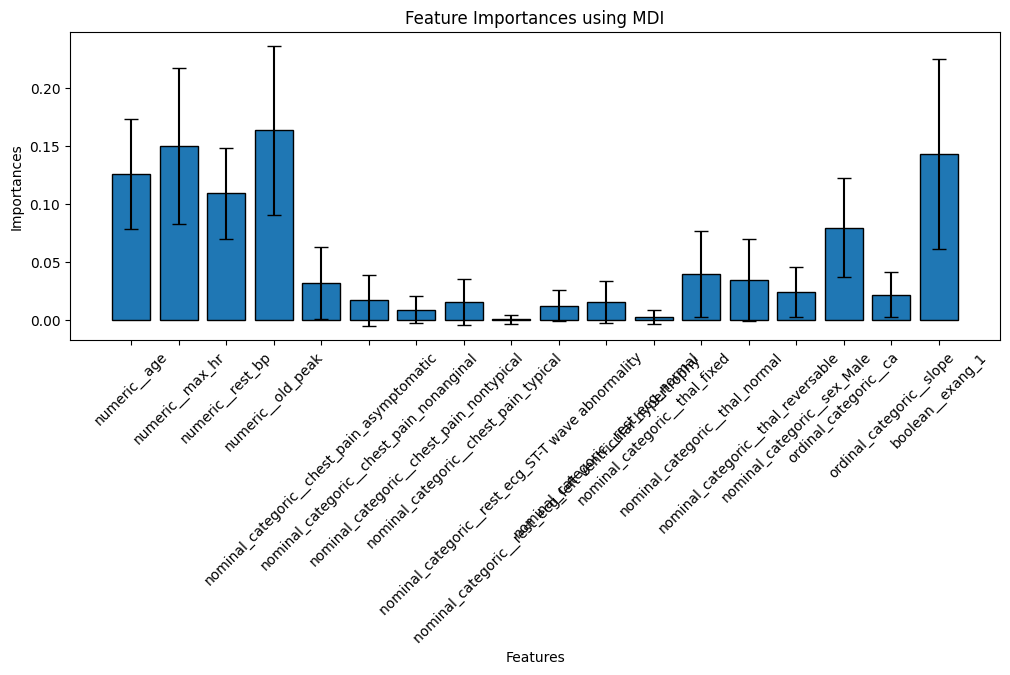

In [12]:
# Create the bar plot
plt.figure(figsize=(12, 4))
plt.bar(
    dfFeatures["Features"],
    dfFeatures["Importances"],
    yerr=dfFeatures["std"],
    capsize=5,
    edgecolor="black",
)

# Añadir etiquetas y título
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Feature Importances using MDI")
plt.xticks(rotation=45);


### **3. Feature permutation**

In [13]:
# Drop columns with low correlation with the target
hd_df.drop(columns=['fbs', 'chol'], inplace=True)

#### **Duplicated Data**

In [14]:
duplicate_rows = hd_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  6347


In [15]:
hd_df = hd_df.drop_duplicates()
hd_df.shape

(501, 12)

In [17]:
X_features = hd_df.drop("disease", axis="columns")
Y_target = hd_df["disease"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [18]:
imps = permutation_importance(
    hd_model, x_test, y_test, scoring="recall", n_repeats=10, random_state=42, n_jobs=8
)

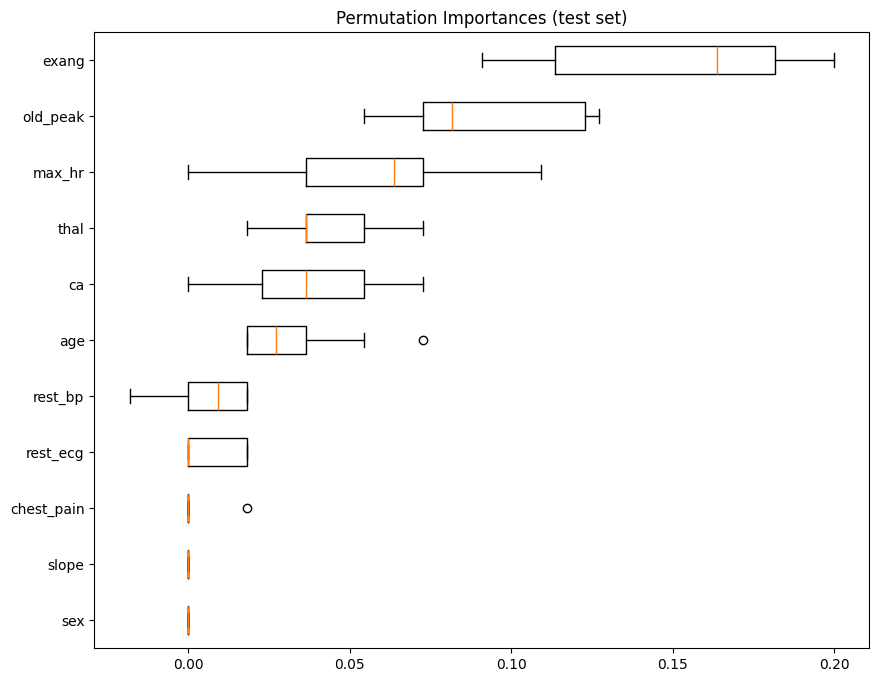

In [19]:
fig = plt.figure(figsize=(10, 8))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(
    imps.importances[perm_sorted_idx].T, vert=False, tick_labels=x_test.columns[perm_sorted_idx]
)
plt.title("Permutation Importances (test set)");

Variables with more predictive power will have a higher impact on the model’s performance when permuted.Based on the results, the most important features are:

- exang
- old_peak
- max_hr

With moderate importance:

- thal
- ca
- age

The results are consistent with the feature analysis.

# **Heart Disease Model Analysis**

## **Feature Importance Analysis**  
The analysis of feature importances using **permutation importance** and **mean decrease in impurity (MDI)** reveals the following key insights:

### **1. Most Important Features**  
- **Exercise-Induced Angina (`exang`)**  
  The most significant predictor, indicating that individuals who experience chest pain during exercise have a higher risk of heart disease.  
- **ST Depression Induced by Exercise (`old_peak`)**  
  A crucial factor related to the heart's ability to handle stress.  
- **Maximum Heart Rate Achieved (`max_hr`)**  
  Plays a key role in determining cardiovascular health.  

### **2. Moderately Important Features**  
- **Thalassemia Type (`thal`)**  
  Certain genetic conditions correlate with heart disease risk.  
- **Number of Major Vessels Colored by Fluoroscopy (`ca`)**  
  Helps assess coronary artery conditions.  
- **Age (`age`)**  
  Older individuals tend to have a higher probability of heart disease.  

### **3. Less Impactful Features**  
- **Resting Blood Pressure (`rest_bp`)**  
  While relevant, it has a lower impact compared to other features.  
- **Electrocardiogram Results (`rest_ecg`)**  
  Slight predictive power but not a primary factor.  
- **Chest Pain Type (`chest_pain`), Slope (`slope`), and Sex (`sex`)**  
  These variables show minimal predictive impact in this specific model.  

---

## **Interpretation & Next Steps**
- The results align with known medical insights, where **exercise responses, heart rate, and vascular health** are primary indicators of heart disease.  
- The **lower importance of sex and chest pain** might suggest a need for feature engineering or more data-driven adjustments.  
- Further analysis on **class imbalance, outliers, and data encoding methods** is required to ensure model robustness.  